In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import seaborn as sns
import uproot as ur
import pandas as pd

from os import listdir, mkdir, getcwd
from os.path import isfile, join, basename, isdir

from sys import platform
#if platform == "linux" or platform == "linux2":
#    import ROOT
#    %jsroot off

#from convert_directory import convert_directory

In [4]:
source_path = getcwd() # "/afs/desy.de/user/b/bliewert/public/MarlinWorkdirs/ZHH/"
output_path = join(source_path, ".npy")

In [10]:
type_map = {
    "int32_t": "i4"
}

def convert_type(type_name: str):
    if type_name in type_map:
        return type_map[type_name]
    else:
        return type_name

def convert_file(source_path, in_file_location, output_path = ""):
    with ur.open(source_path) as file:
        # Find data in file
        data = file[in_file_location]

        # Get correct column names and types for conversion
        dtype_arr = []
        dtype_names = data.typenames()

        for field_name in dtype_names:
            dtype_arr.append((field_name, convert_type(dtype_names[field_name])))

        # Convert data to (column-wise) arrays using numpy
        out = np.zeros(data.num_entries, dtype=dtype_arr)
        keys = data.keys()
        for i in range(0, len(keys)):
            key = keys[i]
            out[key] = data[key].array()

        if output_path != "":
            np.save(output_path, out, allow_pickle=True)

    return out

# See https://uproot.readthedocs.io/en/latest/uproot.behaviors.TBranch.iterate.html
def convert_directory(source_path: str, in_file_location: str, output_dir_abs: str = ""):
    dir_contents = listdir(source_path)
    root_files = filter(lambda filename: filename.endswith(".root"), dir_contents)

    output_dir = source_path
    if output_dir_abs != "":
        output_dir = output_dir_abs

    if not isdir(output_dir_abs):
        mkdir(output_dir_abs)

    for filename in root_files:
        bname = basename(filename)
        output_path = join(output_dir, bname + ".npy")
        if isfile(output_path):
            print("Skipping file <" + bname + "> (exists)")
        else:
            convert_file(join(source_path, filename), in_file_location, output_path)


convert_directory(source_path, "dataTree", output_path)

In [11]:
# Splits a dataframe with separate columns for reco and true properties to one with the properties and a different label "type" with values "true" and "reco" 
def split_event_tree(df,
                     properties=["sigma", "nll"],
                     props_shared=["run", "event", "true_is_zhh", "true_is_zzh", "true_h1_decay1_pdg"],
                     type_names=["true_zhh", "true_zzh"], column_concat: str ="_"):
    #type_dict = {}
    #for property in properties:
    #    type_dict[property] = pd.Series(dtype=df.dtypes[type_names[0] + column_concat + property])

    # Rename
    rename_dict = {}
    for property in properties:
        rename_dict[type_names[0] + column_concat + property] = property

    df = df.rename(columns=rename_dict)
    df["type"] = type_names[0]

    # Slice and re-add
    for type in type_names:
        if type == type_names[0]:
            continue

        #column_names = [word.replace(type + column_concat, "") for word in ["asd_123", "asd_345"]]
        props_type_specific = list(map(lambda cn: type+column_concat+cn, properties))
        props_slice = props_shared + props_type_specific
        sliced = df.loc[:, props_slice]

        df.drop(columns=props_type_specific, inplace=True)

        rename_dict = {}
        for property in properties:
            rename_dict[type + column_concat + property] = property

        sliced.rename(columns=rename_dict, inplace=True)
        sliced["type"] = type

        df = pd.concat([df, sliced])

    df.reset_index(drop=True, inplace=True)

    return df

In [12]:
b = list(map(lambda e: join(output_path, e), listdir(output_path)))
b

['c:\\DevRepositories\\MEM_HEP\\.npy\\compare_out_2.root.npy']

In [13]:
data = pd.DataFrame(np.load(b[0], allow_pickle=True))
data.columns

Index(['run', 'event', 'true_is_zhh', 'true_is_zzh', 'true_h1_decay1_pdg',
       'true_zhh_sigma', 'true_zhh_sigmall', 'true_zhh_sigmalr',
       'true_zhh_sigmarl', 'true_zhh_sigmarr', 'true_zhh_mz', 'true_zhh_mhh',
       'true_zhh_mzhh', 'true_zhh_phi', 'true_zhh_phif', 'true_zhh_phih',
       'true_zhh_costheta', 'true_zhh_costhetaf', 'true_zhh_costhetah',
       'true_zhh_l1_e', 'true_zhh_l1_px', 'true_zhh_l1_py', 'true_zhh_l1_pz',
       'true_zhh_l2_e', 'true_zhh_l2_px', 'true_zhh_l2_py', 'true_zhh_l2_pz',
       'true_zhh_h1_e', 'true_zhh_h1_px', 'true_zhh_h1_py', 'true_zhh_h1_pz',
       'true_zhh_h2_e', 'true_zhh_h2_px', 'true_zhh_h2_py', 'true_zhh_h2_pz',
       'true_zzh_sigma', 'true_zzh_sigmalll', 'true_zzh_sigmallr',
       'true_zzh_sigmalrl', 'true_zzh_sigmalrr', 'true_zzh_sigmarrr',
       'true_zzh_sigmarrl', 'true_zzh_sigmarlr', 'true_zzh_sigmarll',
       'true_zzh_mz1', 'true_zzh_mz2', 'true_zzh_mzz', 'true_zzh_mzzh',
       'true_zzh_phi', 'true_zzh_phiz', 'true

In [14]:
data.dtypes

run                     int32
event                   int32
true_is_zhh             int32
true_is_zzh             int32
true_h1_decay1_pdg      int32
                       ...   
true_zzh_z2f2_pz      float64
true_zzh_h_e          float64
true_zzh_h_px         float64
true_zzh_h_py         float64
true_zzh_h_pz         float64
Length: 76, dtype: object

<AxesSubplot: xlabel='true_h1_decay1_pdg', ylabel='count'>

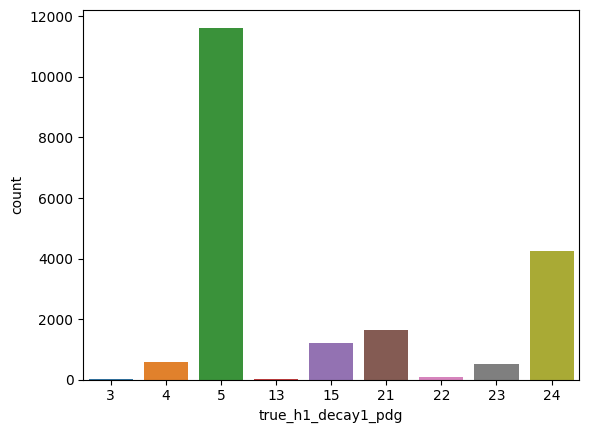

In [15]:
sns.countplot(data, x="true_h1_decay1_pdg")

Important: Unaccounted/"thrown away" events: H->gg,gammagamma,ZZ,W+W-

In [16]:
# Show amount of thrown-away entries
data[(data["true_zhh_sigma"] <= 0) | (data["true_zzh_sigma"] <= 0)].shape

(19900, 76)

In [17]:
# Applying cut
data = data[(data["true_zhh_sigma"] > 0) & (data["true_zzh_sigma"] > 0)]
data.shape

(0, 76)

In [44]:
true_zhh_nll = np.log(data["true_zhh_sigma"])
true_zzh_nll = np.log(data["true_zzh_sigma"])
true_llr = true_zzh_nll/true_zhh_nll

data["true_zhh_nll"] = true_zhh_nll
data["true_zzh_nll"] = true_zzh_nll
data["true_llr"] = true_llr

/tmp/ipykernel_36439/4056746590.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["true_zhh_nll"] = true_zhh_nll
/tmp/ipykernel_36439/4056746590.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["true_zzh_nll"] = true_zzh_nll
/tmp/ipykernel_36439/4056746590.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/us

In [46]:
data_split = split_event_tree(data)

<Axes: xlabel='sigma', ylabel='Count'>

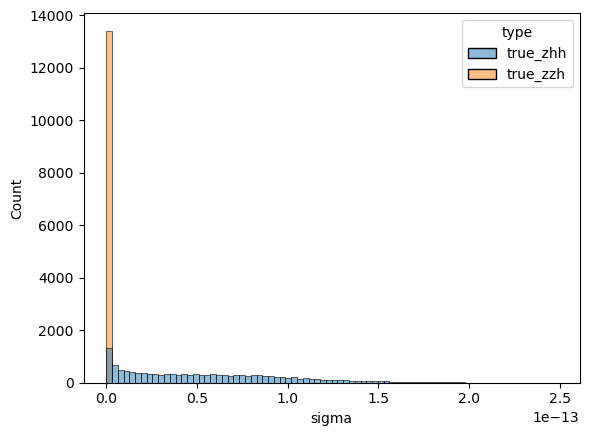

In [47]:
sns.histplot(data_split, x="sigma", hue="type")

<Axes: xlabel='nll', ylabel='Count'>

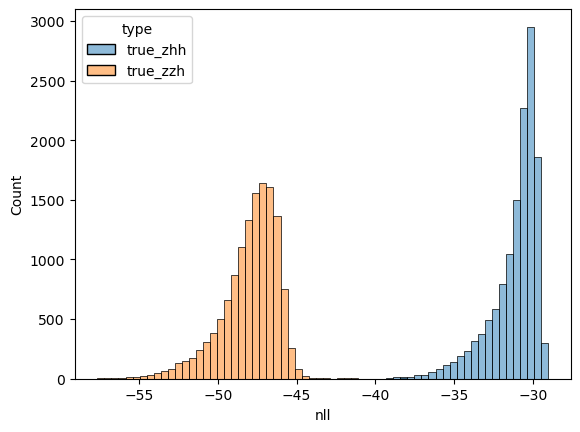

In [49]:
sns.histplot(data_split, x="nll", hue="type", bins=64)

In [9]:
data.shape

(19900, 65)

In [11]:
data_split = split_event_tree(data)
data_split

,run,event,true_is_zhh,true_is_zzh,sigma,sigmall,sigmalr,sigmarl,sigmarr,true_zhh_mz,...,true_zzh_l2_pz,true_zzh_h1_e,true_zzh_h1_px,true_zzh_h1_py,true_zzh_h1_pz,true_zzh_h2_e,true_zzh_h2_px,true_zzh_h2_py,true_zzh_h2_pz,type
0,403001,1,1,0,0.0,0.0,0.0,0.0,0.0,90.566605,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,true_zhh
1,403001,2,1,0,0.0,0.0,0.0,0.0,0.0,91.628563,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,true_zhh
2,403001,3,1,0,0.0,0.0,0.0,0.0,0.0,90.209305,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,true_zhh
3,403001,4,1,0,0.0,0.0,0.0,0.0,0.0,72.617577,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,true_zhh
4,403001,5,1,0,0.0,0.0,0.0,0.0,0.0,81.175934,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,true_zhh
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39795,403001,19896,1,0,0.0,0.0,0.0,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,true_zzh
39796,403001,19897,1,0,0.0,0.0,0.0,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,true_zzh
39797,403001,19898,1,0,0.0,0.0,0.0,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,true_zzh
39798,403001,19899,1,0,0.0,0.0,0.0,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,true_zzh


<Axes: xlabel='true_zzh_sigma', ylabel='Count'>

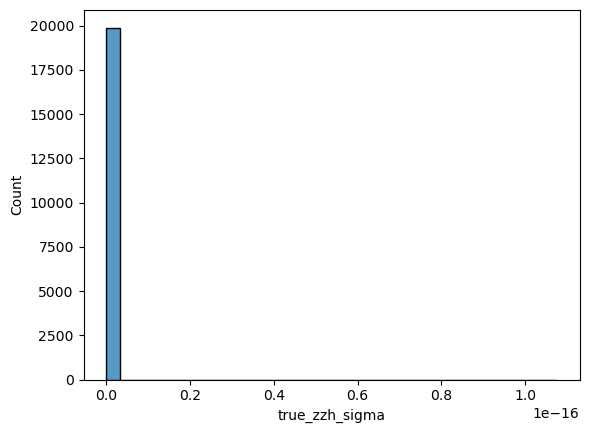

In [16]:
sns.histplot(data["true_zzh_sigma"], bins=32)

In [12]:
def plot_pplot(title:str, file_prefix:str, data_split, vars=["sigma", "sigmalr", "mz", "phif"]):
    f = sns.pairplot(data_split, hue="type", plot_kws=dict( alpha=0.3 ), corner=True)
    f.fig.suptitle(title, y=1.01)

    #plt.savefig(file_prefix + "_pairplot.pdf")

def plot_hists(title:str, file_prefix:str, data):
    fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(12., 8.)) # layout="constrained"
    fig.suptitle(title)

    cmap = sns.color_palette("Blues", as_cmap=True)

    # Seaborn: unweighted (linear) histograms
    f1 = sns.histplot(data=data, x="true_phif", y="true_mz", bins=(24,64), cbar=True, vmin=0, vmax=250, ax=axs[0][0])
    f1.set(xlim=(-3.142,3.142), ylim=(80,102), title="Unweighted")

    f2 = sns.histplot(data=data, x="reco_phif", y="reco_mz", bins=(24,64), cbar=True, vmin=0, vmax=250, ax=axs[1][0])
    f2.set(xlim=(-3.142,3.142), ylim=(80,102), title="Unweighted")

    # Matplotlib: weighted (log) histograms
    if False:
        x = "true_phif"
        y = "true_mz"
        counts, xedges, yedges, im = axs[0][1].hist2d(data=data, x=x, y=y, cmap=cmap, bins=(24,16), range=[[-3.142,3.142], [80, 102]], norm="log", weights=1/data["true_sigmalr"])
        fig.colorbar(im, ax=axs[0][1], location='right')

        x = "reco_phif"
        y = "reco_mz"
        counts, xedges, yedges, im = axs[1][1].hist2d(data=data, x=x, y=y, cmap=cmap, bins=(24,16), range=[[-3.142,3.142], [80, 102]], norm="log", weights=1/data["reco_sigmalr"])
        fig.colorbar(im, ax=axs[1][1], location='right')

    f3 = sns.histplot(data=data, x="true_phif", y="true_mz", bins=(24,64), cbar=True, vmin=0, ax=axs[0][1], weights=(1/data["true_sigmalr"]) )
    f3.set(xlim=(-3.142,3.142), ylim=(80,102), title="Weighted")

    f4 = sns.histplot(data=data, x="reco_phif", y="reco_mz", bins=(24,64), cbar=True, vmin=0, ax=axs[1][1], weights=(1/data["reco_sigmalr"]) )
    f4.set(xlim=(-3.142,3.142), ylim=(80,102), title="Weighted")

    fig.tight_layout()
    #plt.savefig(file_prefix + "_unwt_vs_wt.pdf")

In [13]:
def plot_legoplot(x, y, xlim, ylim, xbins, ybins):
    fig = plt.figure() #create a canvas, tell matplotlib it's 3d
    ax = fig.add_subplot(111, projection='3d')

    hist, xedges, yedges = np.histogram2d(x, y, bins=(xbins, ybins), range = [xlim, ylim])
    xpos, ypos = np.meshgrid(xedges[:-1]+xedges[1:], yedges[:-1]+yedges[1:]) -(xedges[1]-xedges[0])

    xpos = xpos.flatten()*1./2
    ypos = ypos.flatten()*1./2
    zpos = np.zeros_like (xpos)

    dx = xedges [1] - xedges [0]
    dy = yedges [1] - yedges [0]
    dz = hist.flatten()

    cmap = cm.get_cmap('tab20') # Get desired colormap - you can change this!
    max_height = np.max(dz)   # get range of colorbars so we can normalize
    min_height = np.min(dz)
    # scale each z to [0,1], and get their rgb values
    rgba = [cmap((k-min_height)/max_height) for k in dz] 

    ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color=rgba, zsort='average')
    #plt.title("X vs. Y Amplitudes for ____ Data")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.show()

    return ax


In [16]:
ROOT.kRainBow

55

In [87]:
ROOT.gStyle.SetPalette(ROOT.kViridis)

# See https://root.cern.ch/doc/master/classTColor.html
ROOT.gStyle.SetHistLineColor( 1 )

# https://root.cern.ch/doc/master/classTPaveStats.html
ROOT.gStyle.SetOptStat( int("1110", 10) )

In [131]:
# Styling as per https://ipnp.cz/scheirich/?page_id=277
# AtlasStyle: https://github.com/nickcedwards/python-utils/blob/master/AtlasStyle.py

def plot_legoplot_root(x, y, xlim, ylim, xbins = 40, ybins = 40, title="", name="", labels = ("m_{Z}", "#phi_{f}"), units = ("GeV", ""), colorbar=False, weights = None):
    canv = ROOT.TCanvas("c_name", "c_title", 800, 600)
    hlego = ROOT.TH2I(name, title, xbins, xlim[0], xlim[1], ybins, ylim[0], ylim[1])

    xaxis = hlego.GetXaxis()
    yaxis = hlego.GetYaxis()

    xaxis.SetTitle(labels[0] + (" [" + units[0] + "]" if units[0] != "" else ""))
    yaxis.SetTitle(labels[1] + (" [" + units[1] + "]" if units[1] != "" else ""))

    xaxis.SetTitleOffset(1.7)
    yaxis.SetTitleOffset(1.7)

    xaxis.CenterTitle(1)
    yaxis.CenterTitle(1)

    #fig.FillN(len(x), x, y, 1)
    for i in range(0, len(x)):
        hlego.Fill(x[i], y[i])

    hlego.Draw("LEGO2" + ("Z" if colorbar else ""))

    ROOT.gPad.Update()

    # Adjust statsbox; possible only after drawing
    # See https://root.cern.ch/doc/master/classTPaveStats.html
    statsbox = hlego.FindObject("stats")
    statsbox.SetX1NDC(0.65)
    statsbox.SetX2NDC(0.9)
    statsbox.SetY1NDC(0.7)
    statsbox.SetY2NDC(0.9)

    # Adjust colorbar
    if colorbar:
        cbar = hlego.FindObject("palette")

    #canv.Print(join(source_path, "hist.png"))
    canv.Draw()

    return [canv, hlego]


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_name
Warning in <TROOT::Append>: Replacing existing TH1: Plot (Potential memory leak).


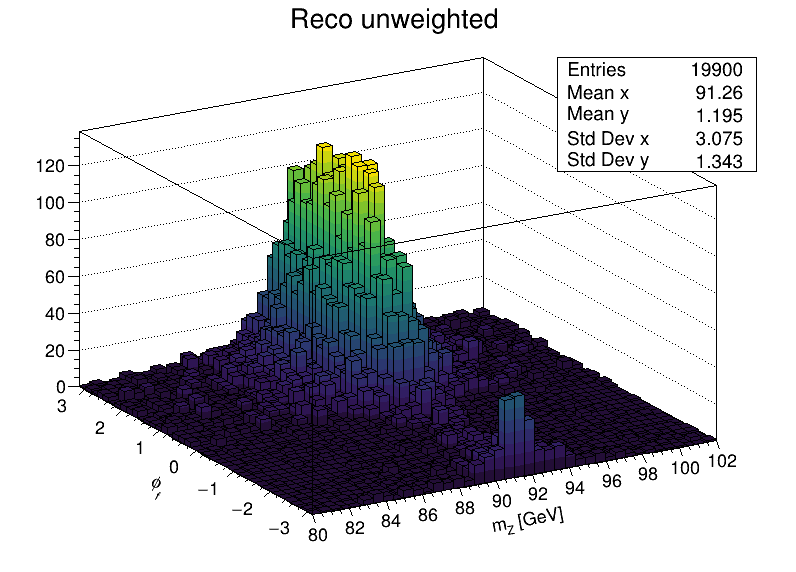

In [132]:
plot_legoplot_root(x=data["reco_mz"], y=data["reco_phif"], xlim=(80, 102), ylim=(-3.142, +3.142), title="Reco unweighted", name="Plot")